In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

indoor_path_1 = "Customer_s Behaviour Case Study\\Indoor Device Data 1.csv"
indoor_path_2 = "Customer_s Behaviour Case Study\\Indoor Device Data 2.csv"
outdoor_path = "Customer_s Behaviour Case Study\\Outdoor Monitor Data.csv"
indoor_metadata_path = "Customer_s Behaviour Case Study\\Indoor Metadata.xlsx"
outdoor_metadata_path = "Customer_s Behaviour Case Study\\Outdoor Metadata.csv"

indoor1 = pd.read_csv(indoor_path_1, sep='\t' ,encoding='UTF-16', low_memory=False)
indoor2 = pd.read_csv(indoor_path_2, sep='\t', encoding='UTF-16', low_memory=False)

# Merge both
indoor = pd.concat([indoor1, indoor2], ignore_index=True)

outdoor = pd.read_csv(outdoor_path, sep='\t', encoding='UTF-16', low_memory=False)
indoor_meta = pd.read_excel(indoor_metadata_path)
outdoor_meta = pd.read_csv(outdoor_metadata_path, sep=';')

In [16]:
# Get list of actual users in the indoor time-series data
active_user_ids = indoor['Member Uuid'].unique()

# Filter metadata to only users present in the time series
filtered_metadata = indoor_meta[indoor_meta['Member Uuid'].isin(active_user_ids)].copy()


In [17]:
# Separate device types
purifiers = indoor_meta[indoor_meta['Device Type'].isin(['pure40', 'pure60'])]
monitors = indoor_meta[indoor_meta['Device Type'] == 'airtest']

# Build mapping: {user_id: {'purifier': [...], 'monitor': [...]}}
from collections import defaultdict

user_devices = defaultdict(dict)
for uid in indoor_meta['Member Uuid'].unique():
    user_devices[uid] = {
        'purifier': purifiers[purifiers['Member Uuid'] == uid]['Device Name'].tolist(),
        'monitor': monitors[monitors['Member Uuid'] == uid]['Device Name'].tolist()
    }


In [18]:
aligned_data = []

indoor['Timestamp'] = pd.to_datetime(indoor['Timestamp'], format='%d/%m/%Y %H.%M')
outdoor['Timestamp'] = pd.to_datetime(outdoor['Timestamp'], format='%d %B %Y at %H.%M')

for uid, devices in user_devices.items():
    purifiers = indoor[indoor['Device Name'].isin(devices['purifier'])]
    monitors = indoor[indoor['Device Name'].isin(devices['monitor'])]

    # Clean + reduce
    purifier_df = purifiers[['Timestamp', 'Power', 'Mode', 'Speed', 'Device Name']]
    monitor_df = monitors[['Timestamp', 'Pm25', 'Temperature', 'Humidity', 'Device Name']]

    # Merge on Timestamp
    user_df = pd.merge_asof(
        purifier_df.sort_values('Timestamp'),
        monitor_df.sort_values('Timestamp'),
        on='Timestamp',
        direction='nearest',
        tolerance=pd.Timedelta('10m')  # assuming 10-minute frequency
    )

    # Add user context
    user_df['Member Uuid'] = uid
    user_df['Latitude'] = indoor_meta.loc[indoor_meta['Member Uuid'] == uid, 'Latitude'].iloc[0]
    user_df['Longitude'] = indoor_meta.loc[indoor_meta['Member Uuid'] == uid, 'Longitude'].iloc[0]

    aligned_data.append(user_df)

# Final full user-centric DataFrame
full_user_df = pd.concat(aligned_data, ignore_index=True)


In [19]:
from geopy.distance import great_circle


# Build user → station mapping
user_coords = indoor_meta.groupby('Member Uuid')[['Latitude', 'Longitude']].mean()
station_coords = outdoor_meta[['Name', 'Latitude', 'Longitude']]

user_coords

,Latitude,Longitude
Member Uuid,,
4940f5d2-f23a-4bf7-aa60-4875ffd19a8a,-6.287932,106.799911
512f3d17-94ea-4608-8c0a-debf385c6a51,-6.230850,106.794883
5bb696fb-e41a-44bd-b288-5830e671dd73,NaN,NaN
a0374cb9-47a8-4a2e-98b7-bac12f3903cf,-6.221237,106.785798
a75f6f00-595e-47e6-b944-18e91a8f6bc9,-6.253483,106.803246
bb7c99e6-84cb-487a-a5d4-45ba471e35d4,-6.253535,106.805463
ec2d3945-8687-4d25-9ea6-3181bc072521,-6.276847,106.782850
fd901e04-f3d3-4667-929c-1fdd834854b2,-6.291002,106.753701
ff8ba950-1778-4fbb-9aab-b806bae077c4,-6.237352,106.785901


In [22]:
# Drop users without location
user_coords_clean = user_coords.dropna(subset=['Latitude', 'Longitude'])
station_coords_clean = station_coords.dropna(subset=['Latitude', 'Longitude'])

nearest_station = {}

for uid, row in user_coords_clean.iterrows():
    user_loc = (row['Latitude'], row['Longitude'])

    # Compute distances only for valid stations
    distances = station_coords_clean[['Latitude', 'Longitude']].apply(
        lambda x: great_circle(user_loc, (x['Latitude'], x['Longitude'])).km, axis=1
    )

    closest_idx = distances.idxmin()
    nearest_station[uid] = station_coords_clean.loc[closest_idx, 'Name']  # or 'Name' if that's your column

valid_uids = list(nearest_station.keys())

# Filter full_user_df before looping
full_user_df_filtered = full_user_df[full_user_df['Member Uuid'].isin(valid_uids)]


# # Find nearest station
# nearest_station = {}
# for uid, row in user_coords.iterrows():
#     user_loc = (row['Latitude'], row['Longitude'])
#     closest = station_coords.loc[
#         station_coords[['Latitude', 'Longitude']].apply(
#             lambda x: great_circle(user_loc, (x['Latitude'], x['Longitude'])).km, axis=1
#         ).idxmin()
#     ]
#     nearest_station[uid] = closest['Name']

final_aligned = []

for uid, df in full_user_df_filtered.groupby('Member Uuid'):
    station_id = nearest_station[uid]
    station_df = outdoor[outdoor['Name'] == station_id][['Timestamp', 'Avg. Pm25']]
    station_df = station_df.rename(columns={'Avg. Pm25': 'Outdoor_Pm25'})

    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    station_df['Timestamp'] = pd.to_datetime(station_df['Timestamp'])

    merged = pd.merge_asof(
        df.sort_values('Timestamp'),
        station_df.sort_values('Timestamp'),
        on='Timestamp',
        direction='nearest',
        tolerance=pd.Timedelta('10min')
    )
    final_aligned.append(merged)

user_behavior_df = pd.concat(final_aligned, ignore_index=True)



# PM2.5 spikes and user reaction

In [30]:
# Detect significant indoor spikes
user_behavior_df['Indoor_Pm25_Change'] = user_behavior_df.groupby('Member Uuid')['Pm25'].diff()
user_behavior_df['Indoor_Spike'] = user_behavior_df['Indoor_Pm25_Change'] > 15  # threshold: 15 µg/m³ increase

# Detect outdoor spikes similarly
user_behavior_df['Outdoor_Pm25_Change'] = user_behavior_df.groupby('Member Uuid')['Outdoor_Pm25'].diff()
user_behavior_df['Outdoor_Spike'] = user_behavior_df['Outdoor_Pm25_Change'] > 20


In [31]:
## POWER ON USER BEHAVIOUR

user_behavior_df['Power_shifted'] = user_behavior_df.groupby('Member Uuid')['Power'].shift(-1)
user_behavior_df['Manual_Reaction'] = (
    (user_behavior_df['Indoor_Spike']) &
    (user_behavior_df['Power_shifted'] == 1) &
    (user_behavior_df['Mode'] == 'MANUAL')
)


In [32]:
user_response = user_behavior_df.groupby('Member Uuid').agg({
    'Manual_Reaction': 'sum',
    'Indoor_Spike': 'sum',
    'Outdoor_Spike': 'sum',
    'Power': 'mean',  # ON ratio
    'Pm25': 'mean',   # average exposure
    'Mode': lambda x: (x == 'MANUAL').mean()  # manual mode ratio
}).rename(columns={
    'Manual_Reaction': 'Manual_Reactions',
    'Power': 'Avg_On_Ratio',
    'Pm25': 'Avg_Indoor_PM2.5',
    'Mode': 'Manual_Mode_Ratio'
})

# Add reactivity rate
user_response['Reactivity_Rate'] = user_response['Manual_Reactions'] / user_response['Indoor_Spike'].replace(0, np.nan)


## PLOTS

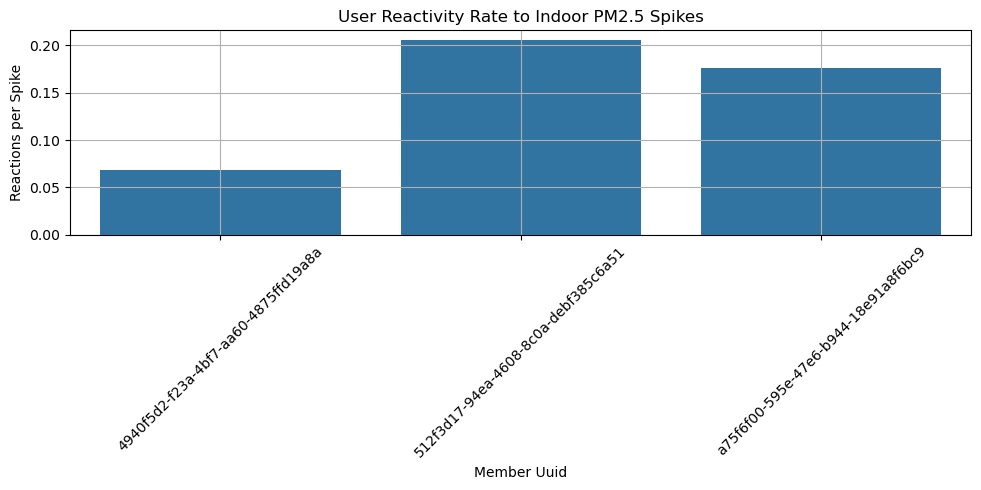

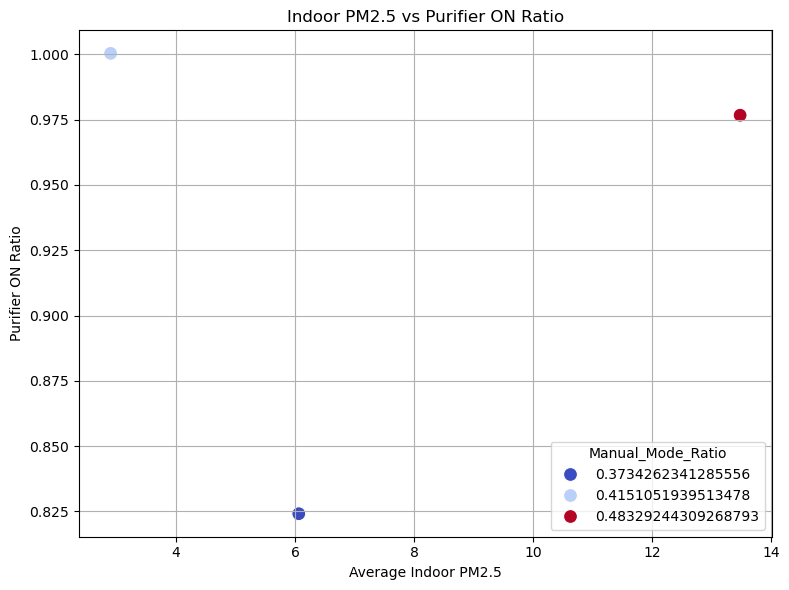

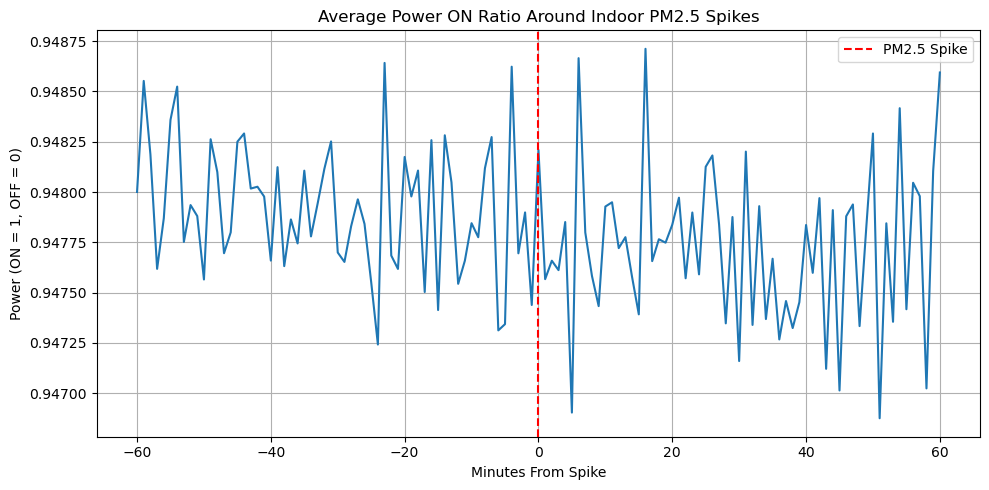

C:\Users\saisr\AppData\Local\Temp\ipykernel_11044\56931774.py:67: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\saisr\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


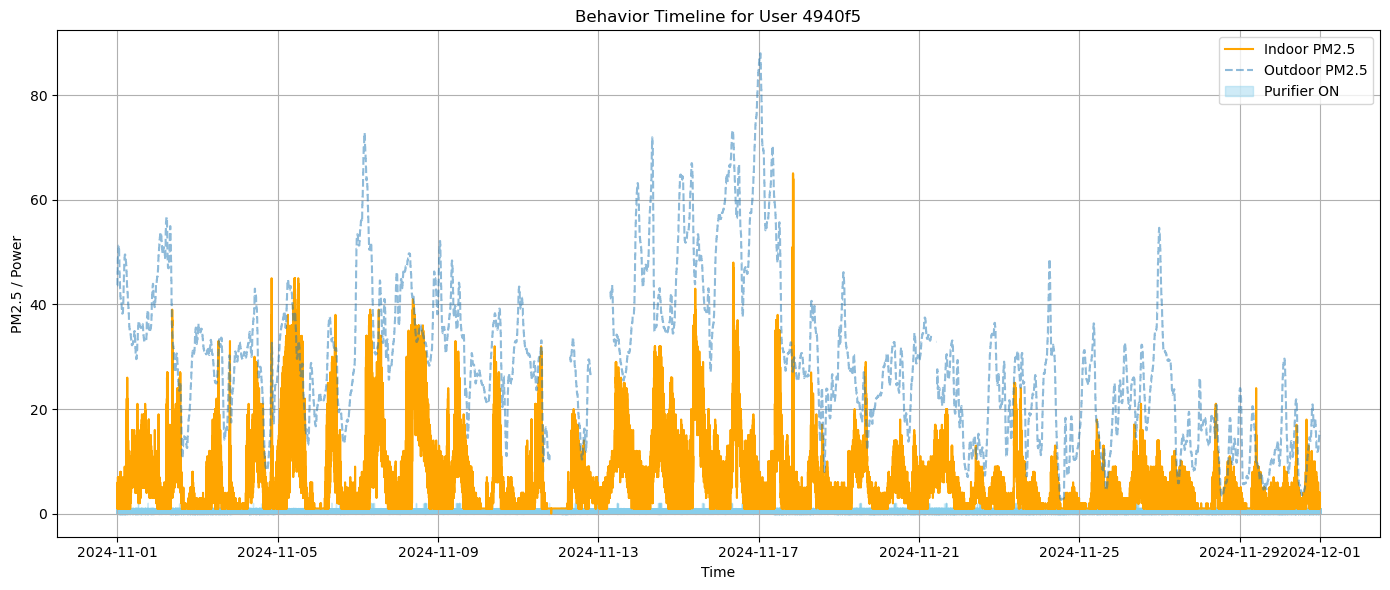

<Axes: xlabel='User Type', ylabel='Avg_Indoor_PM2.5'>

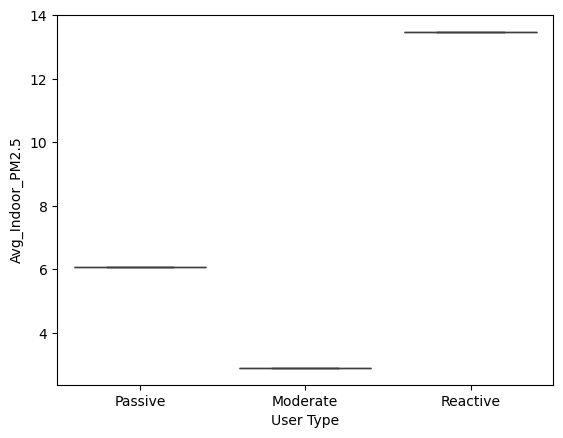

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.barplot(data=user_response.reset_index(), x='Member Uuid', y='Reactivity_Rate')
plt.title('User Reactivity Rate to Indoor PM2.5 Spikes')
plt.ylabel('Reactions per Spike')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=user_response, x='Avg_Indoor_PM2.5', y='Avg_On_Ratio', hue='Manual_Mode_Ratio', palette='coolwarm', s=100)
plt.title('Indoor PM2.5 vs Purifier ON Ratio')
plt.xlabel('Average Indoor PM2.5')
plt.ylabel('Purifier ON Ratio')
plt.grid(True)
plt.tight_layout()
plt.show()


# Step 1: create a 3-hour window around each spike
window = pd.Timedelta(minutes=60)
heatmap_data = []

for uid, group in user_behavior_df.groupby('Member Uuid'):
    spikes = group[group['Indoor_Spike'] == True]['Timestamp']
    for spike_time in spikes:
        window_df = group[(group['Timestamp'] >= spike_time - window) & 
                          (group['Timestamp'] <= spike_time + window)].copy()
        if len(window_df) == 0: continue
        window_df['Minutes_From_Spike'] = (window_df['Timestamp'] - spike_time).dt.total_seconds() / 60
        window_df['User'] = uid
        heatmap_data.append(window_df[['Minutes_From_Spike', 'Power', 'User']])

import pandas as pd
heat_df = pd.concat(heatmap_data)
heatmap_avg = heat_df.groupby('Minutes_From_Spike')['Power'].mean().reset_index()

# Step 2: plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=heatmap_avg, x='Minutes_From_Spike', y='Power')
plt.axvline(0, color='red', linestyle='--', label='PM2.5 Spike')
plt.title('Average Power ON Ratio Around Indoor PM2.5 Spikes')
plt.xlabel('Minutes From Spike')
plt.ylabel('Power (ON = 1, OFF = 0)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Select one user
uid = user_behavior_df['Member Uuid'].unique()[0]
single_user = user_behavior_df[user_behavior_df['Member Uuid'] == uid].copy()

plt.figure(figsize=(14,6))
plt.plot(single_user['Timestamp'], single_user['Pm25'], label='Indoor PM2.5', color='orange')
plt.plot(single_user['Timestamp'], single_user['Outdoor_Pm25'], label='Outdoor PM2.5', alpha=0.5, linestyle='--')
plt.fill_between(single_user['Timestamp'], 0, single_user['Power'], color='skyblue', alpha=0.4, label='Purifier ON')

plt.legend()
plt.title(f'Behavior Timeline for User {uid[:6]}')
plt.ylabel('PM2.5 / Power')
plt.xlabel('Time')
plt.grid(True)
plt.tight_layout()
plt.show()

user_response['User Type'] = pd.qcut(user_response['Reactivity_Rate'], q=3, labels=['Passive', 'Moderate', 'Reactive'])
sns.boxplot(data=user_response, x='User Type', y='Avg_Indoor_PM2.5')


In [29]:
print("Total Indoor Spikes:", user_behavior_df['Indoor_Spike'].sum())
print("Total Outdoor Spikes:", user_behavior_df['Outdoor_Spike'].sum())
print("Manual reactions detected:", user_behavior_df['Manual_Reaction'].sum())



Total Indoor Spikes: 4518
Total Outdoor Spikes: 2
Manual reactions detected: 0


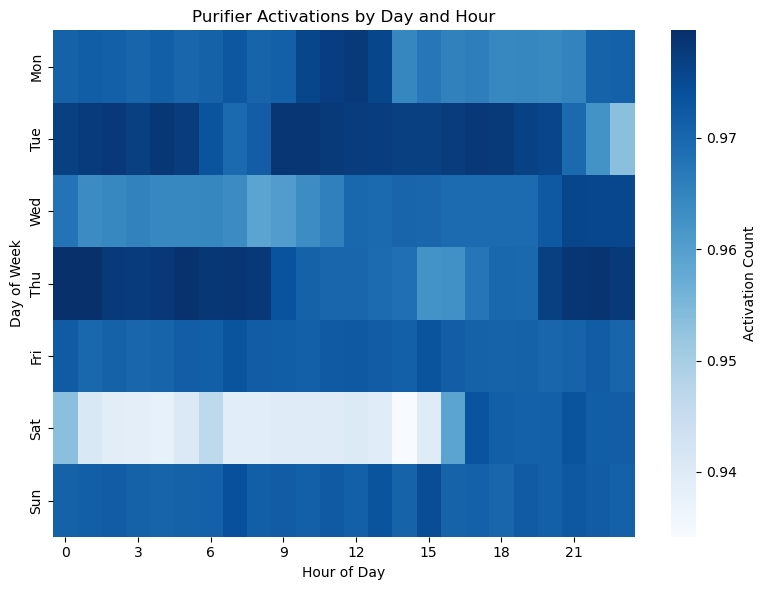

ValueError: could not convert string to float: 'Friday'

<Figure size 1200x600 with 0 Axes>

In [ ]:
indoor_reset = indoor.reset_index()
indoor_reset['hour'] = indoor_reset['Timestamp'].dt.hour
indoor_reset['dayofweek'] = indoor_reset['Timestamp'].dt.day_name()

day_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
usage_heatmap = indoor_reset.groupby(['dayofweek', 'hour'])['Power'].mean().reset_index()

pivot = usage_heatmap.pivot(index='dayofweek', columns='hour', values='Power')



plt.figure(figsize=(8, 6))
sns.heatmap(pivot, cmap='Blues', xticklabels=3, yticklabels=day_labels, cbar_kws={'label': 'Activation Count'})
plt.title('Purifier Activations by Day and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()


# usage_heatmap = usage_heatmap.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# plt.figure(figsize=(12, 6))
# sns.heatmap(usage_heatmap, cmap='YlGnBu', annot=False)
# plt.title("Purifier Usage Heatmap by Day and Hour")
# plt.xlabel("Hour")
# plt.ylabel("Day of Week")
# plt.tight_layout()
# plt.show()

In [37]:
# Get events where the purifier turned ON in manual mode
user_behavior_df['Prev_Power'] = user_behavior_df.groupby('Member Uuid')['Power'].shift(1)

# Detect transitions from OFF to ON (manual only)
threshold_events = user_behavior_df[
    (user_behavior_df['Power'] == 1) &
    (user_behavior_df['Prev_Power'] == 0) &
    (user_behavior_df['Mode'] == 'manual') &
    (user_behavior_df['Pm25'].notnull())
]

# Group by user to analyze trigger levels
pm25_thresholds = threshold_events.groupby('Member Uuid')['Pm25'].apply(list)


C:\Users\saisr\AppData\Local\Temp\ipykernel_11044\575492110.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='User ID')


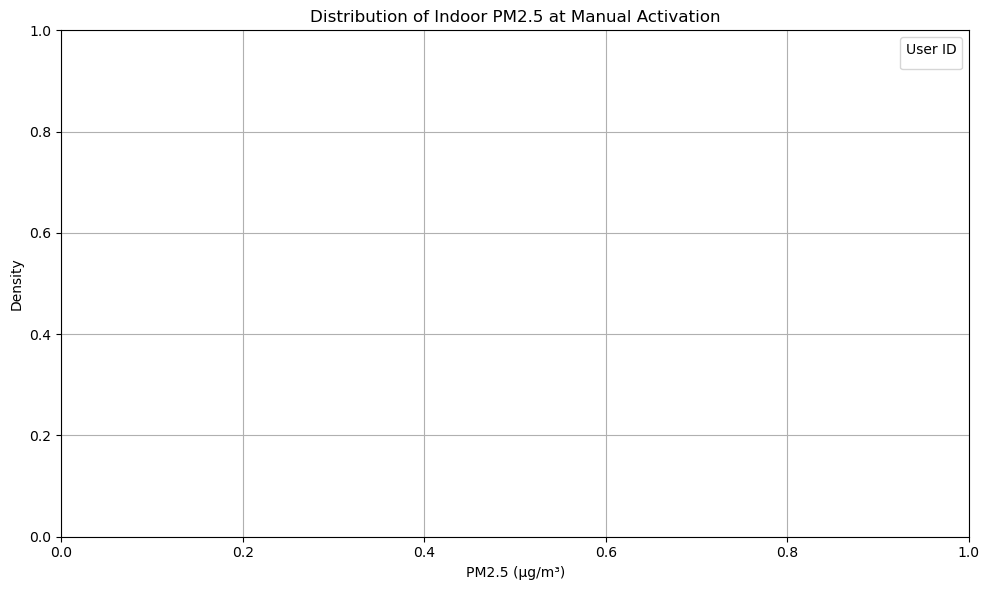

TypeError: Series.sort_values() takes 1 positional argument but 2 were given

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

for uid, values in pm25_thresholds.items():
    sns.kdeplot(values, label=uid[:5], fill=True)

plt.title('Distribution of Indoor PM2.5 at Manual Activation')
plt.xlabel('PM2.5 (µg/m³)')
plt.ylabel('Density')
plt.legend(title='User ID')
plt.grid(True)
plt.tight_layout()
plt.show()


threshold_summary = pm25_thresholds.apply(lambda x: {
    'mean_threshold': np.mean(x),
    'median_threshold': np.median(x),
    'trigger_count': len(x)
}).apply(pd.Series)

threshold_summary = threshold_summary.sort_values('median_threshold')
print(threshold_summary)


C:\Users\saisr\AppData\Local\Temp\ipykernel_11044\2702004967.py:20: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(values, label=uid[:5], fill=True)


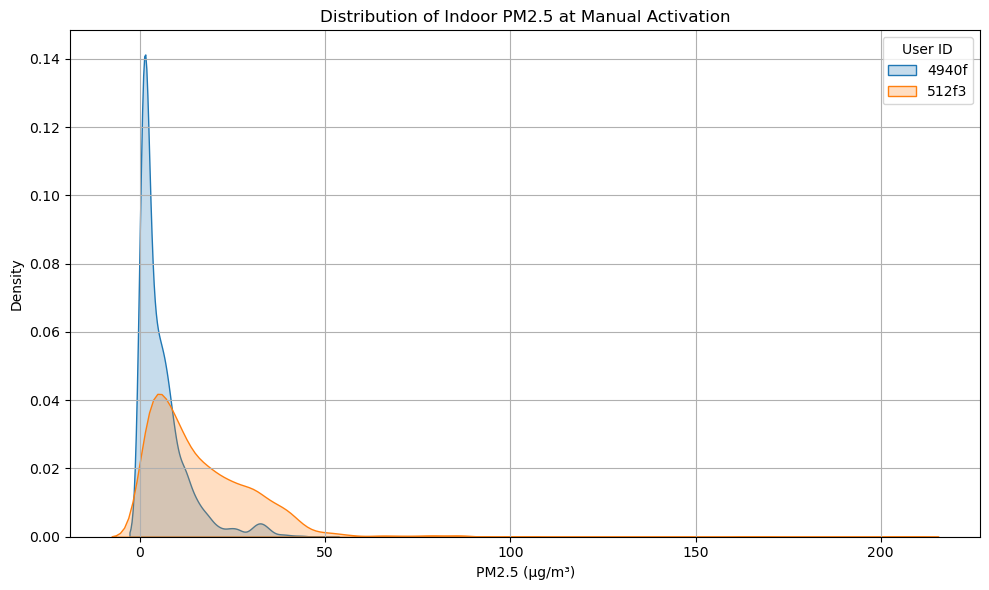

                                      mean_threshold  median_threshold  \
Member Uuid                                                              
a75f6f00-595e-47e6-b944-18e91a8f6bc9        2.000000               2.0   
4940f5d2-f23a-4bf7-aa60-4875ffd19a8a        5.857726               3.0   
512f3d17-94ea-4608-8c0a-debf385c6a51       16.264974              12.0   

                                      trigger_count  
Member Uuid                                          
a75f6f00-595e-47e6-b944-18e91a8f6bc9            1.0  
4940f5d2-f23a-4bf7-aa60-4875ffd19a8a         4653.0  
512f3d17-94ea-4608-8c0a-debf385c6a51         3072.0  


In [40]:
user_behavior_df['Mode'] = user_behavior_df['Mode'].str.lower()
user_behavior_df['Prev_Power'] = user_behavior_df.groupby('Member Uuid')['Power'].shift(1)

threshold_events = user_behavior_df[
    (user_behavior_df['Power'] == 1) &
    (user_behavior_df['Prev_Power'] == 0) &
    (user_behavior_df['Mode'] == 'manual') &
    (user_behavior_df['Pm25'].notnull())
]

pm25_thresholds = threshold_events.groupby('Member Uuid')['Pm25'].apply(list)

# Plot distributions
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
for uid, values in pm25_thresholds.items():
    if len(values) > 0:
        sns.kdeplot(values, label=uid[:5], fill=True)

plt.title('Distribution of Indoor PM2.5 at Manual Activation')
plt.xlabel('PM2.5 (µg/m³)')
plt.ylabel('Density')
plt.legend(title='User ID')
plt.grid(True)
plt.tight_layout()
plt.show()

# Summary stats
import numpy as np
threshold_summary = pm25_thresholds.apply(lambda x: {
    'mean_threshold': np.mean(x),
    'median_threshold': np.median(x),
    'trigger_count': len(x)
}).apply(pd.Series)

threshold_summary = threshold_summary.sort_values(by='median_threshold')
print(threshold_summary)

C:\Users\saisr\AppData\Local\Temp\ipykernel_11044\548257369.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=threshold_summary, x='User', y='median_threshold', palette='coolwarm')


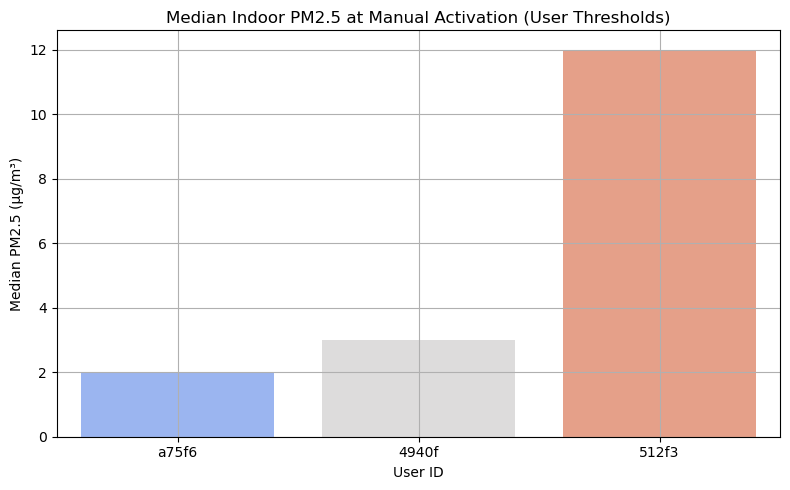

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

threshold_summary['User'] = threshold_summary.index.str[:5]
plt.figure(figsize=(8, 5))
sns.barplot(data=threshold_summary, x='User', y='median_threshold', palette='coolwarm')

plt.title('Median Indoor PM2.5 at Manual Activation (User Thresholds)')
plt.xlabel('User ID')
plt.ylabel('Median PM2.5 (µg/m³)')
plt.grid(True)
plt.tight_layout()
plt.show()


## Auto Mode threshold

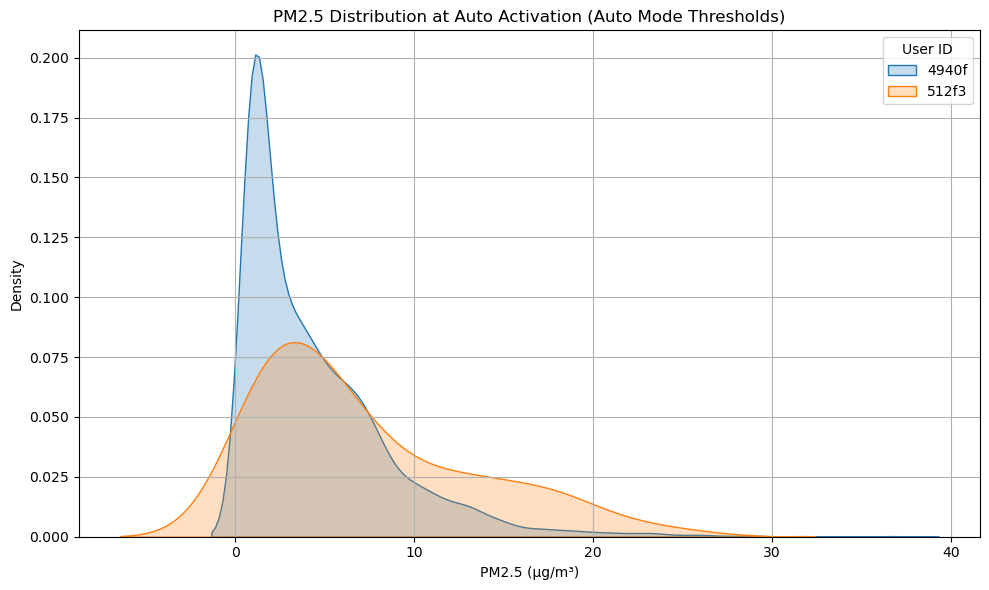

                                      auto_mean  auto_median  \
Member Uuid                                                    
4940f5d2-f23a-4bf7-aa60-4875ffd19a8a   4.447162          3.0   
512f3d17-94ea-4608-8c0a-debf385c6a51   7.207317          5.0   

                                      auto_trigger_count  
Member Uuid                                               
4940f5d2-f23a-4bf7-aa60-4875ffd19a8a              5110.0  
512f3d17-94ea-4608-8c0a-debf385c6a51                82.0  


In [44]:
user_behavior_df['Prev_Power'] = user_behavior_df.groupby('Member Uuid')['Power'].shift(1)
user_behavior_df['Mode'] = user_behavior_df['Mode'].str.lower()  # just in case

# Detect ON transitions while in auto mode
auto_threshold_events = user_behavior_df[
    (user_behavior_df['Power'] == 1) &
    (user_behavior_df['Prev_Power'] == 0) &
    (user_behavior_df['Mode'] == 'auto') &
    (user_behavior_df['Pm25'].notnull())
]

# Group by user to analyze PM2.5 at auto-ON
auto_pm25_thresholds = auto_threshold_events.groupby('Member Uuid')['Pm25'].apply(list)

plt.figure(figsize=(10, 6))

for uid, values in auto_pm25_thresholds.items():
    if len(values) > 0:
        sns.kdeplot(values, label=uid[:5], fill=True)

plt.title('PM2.5 Distribution at Auto Activation (Auto Mode Thresholds)')
plt.xlabel('PM2.5 (µg/m³)')
plt.ylabel('Density')
plt.legend(title='User ID')
plt.grid(True)
plt.tight_layout()
plt.show()

auto_threshold_summary = auto_pm25_thresholds.apply(lambda x: {
    'auto_mean': np.mean(x),
    'auto_median': np.median(x),
    'auto_trigger_count': len(x)
}).apply(pd.Series)

print(auto_threshold_summary)

## Create risk index


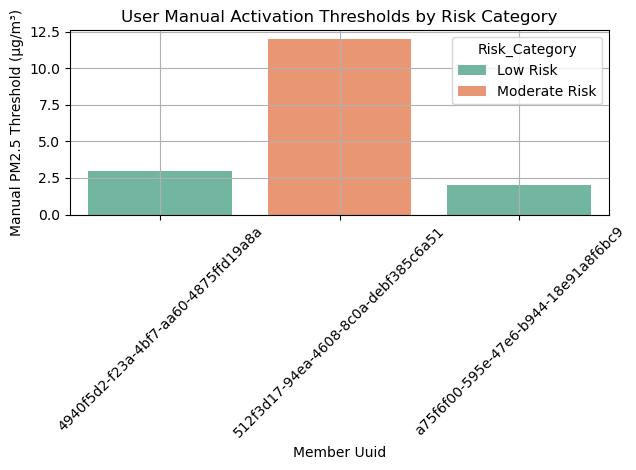

In [45]:
combined = threshold_summary.merge(auto_threshold_summary, left_index=True, right_index=True, how='outer')

# Fill missing with zeros (e.g. if no auto triggers for some users)
combined.fillna({'auto_median': 0, 'auto_mean': 0, 'auto_trigger_count': 0}, inplace=True)

def assign_risk(row):
    if row['median_threshold'] <= 5 and row['auto_median'] <= 10:
        return 'Low Risk'
    elif row['median_threshold'] <= 10 or row['auto_median'] <= 15:
        return 'Moderate Risk'
    else:
        return 'High Risk'

combined['Risk_Category'] = combined.apply(assign_risk, axis=1)

sns.barplot(data=combined.reset_index(), x='Member Uuid', y='median_threshold', hue='Risk_Category', palette='Set2')
plt.title('User Manual Activation Thresholds by Risk Category')
plt.ylabel('Manual PM2.5 Threshold (µg/m³)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


## Indoor vs outdoor pollution

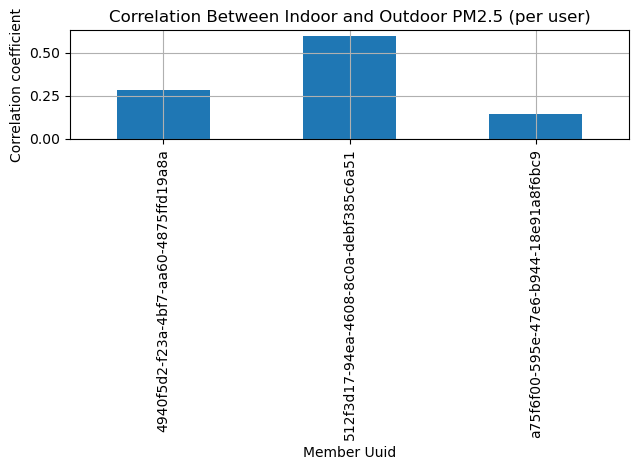

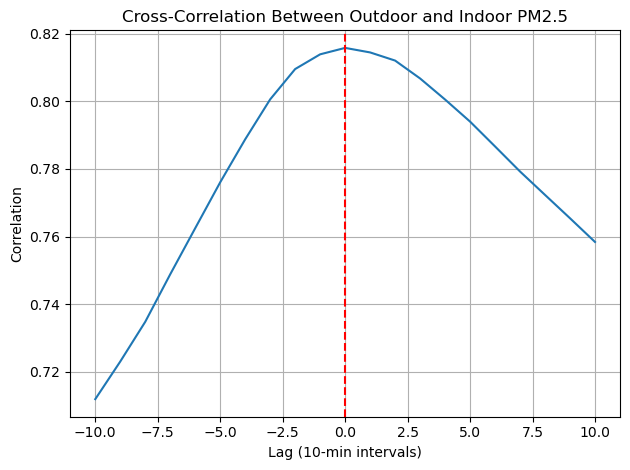

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

corrs = []

for uid, df in user_behavior_df.groupby('Member Uuid'):
    sub = df[['Pm25', 'Outdoor_Pm25']].dropna()
    corr = sub['Pm25'].corr(sub['Outdoor_Pm25'])
    corrs.append({'Member Uuid': uid, 'Corr_PM25': corr})

pd.DataFrame(corrs).set_index('Member Uuid').plot(kind='bar', legend=False)
plt.title("Correlation Between Indoor and Outdoor PM2.5 (per user)")
plt.ylabel("Correlation coefficient")
plt.grid(True)
plt.tight_layout()
plt.show()

### LEAD LAG BETWEEN OUTDOOR AND INDOOR
from statsmodels.tsa.stattools import ccf

def lag_analysis(df, uid):
    sub = df[['Timestamp', 'Pm25', 'Outdoor_Pm25']].dropna()
    sub = sub.set_index('Timestamp').resample('10min').mean().interpolate()

    indoor = sub['Pm25'].values
    outdoor = sub['Outdoor_Pm25'].values

    if len(indoor) < 20:
        return None

    lags = np.arange(-10, 11)
    results = []

    for lag in lags:
        shifted = np.roll(outdoor, lag)
        corr = np.corrcoef(indoor, shifted)[0, 1]
        results.append({'lag': lag, 'corr': corr})

    result_df = pd.DataFrame(results)
    result_df['User'] = uid
    return result_df

# Apply to one user (or all)
user_lag = lag_analysis(user_behavior_df[user_behavior_df['Member Uuid'] == '512f3d17-94ea-4608-8c0a-debf385c6a51'], '512f3d17-94ea-4608-8c0a-debf385c6a51')


if user_lag is not None:
    sns.lineplot(data=user_lag, x='lag', y='corr')
    plt.axvline(0, linestyle='--', color='red')
    plt.title("Cross-Correlation Between Outdoor and Indoor PM2.5")
    plt.xlabel("Lag (10-min intervals)")
    plt.ylabel("Correlation")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Not enough data to analyze lag for this user.")



In [51]:
lag_results = []

for uid in user_behavior_df['Member Uuid'].unique():
    df = user_behavior_df[user_behavior_df['Member Uuid'] == uid]
    lag_df = lag_analysis(df, uid)
    if lag_df is not None:
        max_corr_row = lag_df.loc[lag_df['corr'].idxmax()]
        lag_results.append({
            'Member Uuid': uid,
            'Best Lag (10min)': max_corr_row['lag'],
            'Max Correlation': max_corr_row['corr']
        })

lag_summary = pd.DataFrame(lag_results)
lag_summary.sort_values('Max Correlation', ascending=False)


,Member Uuid,Best Lag (10min),Max Correlation
1,512f3d17-94ea-4608-8c0a-debf385c6a51,0,0.815759
0,4940f5d2-f23a-4bf7-aa60-4875ffd19a8a,10,0.400841
2,a75f6f00-595e-47e6-b944-18e91a8f6bc9,10,0.271537


In [49]:
indoor['Member Uuid'].unique()

array(['5bb696fb-e41a-44bd-b288-5830e671dd73',
       '512f3d17-94ea-4608-8c0a-debf385c6a51',
       '4940f5d2-f23a-4bf7-aa60-4875ffd19a8a',
       'a75f6f00-595e-47e6-b944-18e91a8f6bc9'], dtype=object)

## Other pollutants

In [57]:
from geopy.distance import great_circle

user_station_map = {}

for _, user in indoor_meta.dropna(subset=['Latitude', 'Longitude']).iterrows():
    user_id = user['Member Uuid']
    user_loc = (user['Latitude'], user['Longitude'])

    # Compute distances to all stations
    closest_station = outdoor_meta.dropna(subset=['Latitude', 'Longitude']).copy()
    closest_station['distance_km'] = closest_station.apply(
        lambda row: great_circle(user_loc, (row['Latitude'], row['Longitude'])).km,
        axis=1
    )

    nearest_row = closest_station.loc[closest_station['distance_km'].idxmin()]
    user_station_map[user_id] = nearest_row['Name']  # or 'Station Id' if using ID instead


In [68]:


all_user_frames = []

for uid, station in user_station_map.items():
    indoor_user = indoor[indoor['Member Uuid'] == uid].copy()
    outdoor_station = outdoor[outdoor['Name'] == station].copy()

    # Ensure datetime format
    indoor_user['Timestamp'] = pd.to_datetime(indoor_user['Timestamp'])
    outdoor_station['Timestamp'] = pd.to_datetime(outdoor_station['Timestamp'])

    # Merge using timestamp proximity
    merged = pd.merge_asof(
        indoor_user.sort_values('Timestamp'),
        outdoor_station.sort_values('Timestamp'),
        on='Timestamp',
        direction='nearest',
        tolerance=pd.Timedelta('10min')  # adjust if needed
    )

    merged['Member Uuid'] = uid
    all_user_frames.append(merged)

merged_data = pd.concat(all_user_frames, ignore_index=True)


In [59]:
merged_data.columns

Index(['Member Uuid', 'Device Name', 'Timestamp', 'Mode', 'Humidity', 'Pm25',
       'Power', 'Speed', 'Temperature', 'Name', 'Avg. Co', 'Avg. Humidity',
       'Avg. Pm1', 'Avg. Pm10', 'Avg. Pm25', 'Avg. Pressure', 'Avg. So2',
       'Avg. Temperature'],
      dtype='object')

In [61]:
print(merged_data[features + ['Pm25']].isnull().sum())


Avg. Pm25             71505
Avg. Pm10             71505
Avg. Pm1              71505
Avg. So2            2023974
Avg. Pressure         71505
Avg. Temperature      71505
Avg. Humidity         71505
Pm25                 728944
dtype: int64


In [62]:
features = [
    'Avg. Pm25', 'Avg. Pm10', 'Avg. Pm1', 'Avg. Pressure', 'Avg. Temperature', 'Avg. Humidity'
]

reg_df = merged_data[features + ['Pm25']].dropna()

from sklearn.linear_model import LinearRegression
X = reg_df[features]
y = reg_df['Pm25']

model = LinearRegression()
model.fit(X, y)

# Show coefficients
for feature, coef in zip(features, model.coef_):
    print(f"{feature:20} ➜ {coef:.4f}")


Avg. Pm25            ➜ 1.0338
Avg. Pm10            ➜ -0.5107
Avg. Pm1             ➜ -0.2336
Avg. Pressure        ➜ 0.6356
Avg. Temperature     ➜ 3.4017
Avg. Humidity        ➜ 0.8153


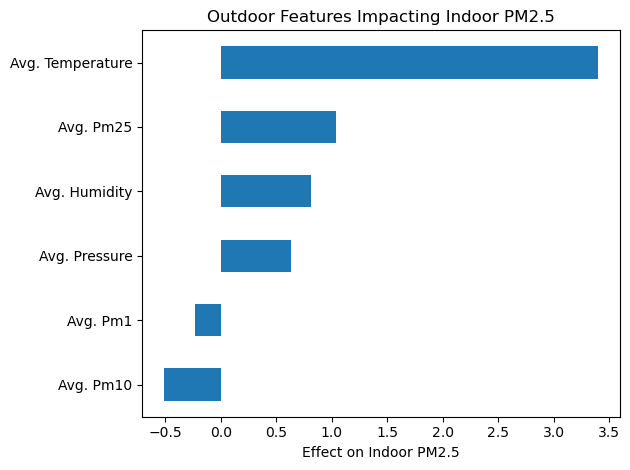

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

coef_series = pd.Series(model.coef_, index=features).sort_values()
coef_series.plot(kind='barh', title='Outdoor Features Impacting Indoor PM2.5')
plt.xlabel('Effect on Indoor PM2.5')
plt.tight_layout()
plt.show()


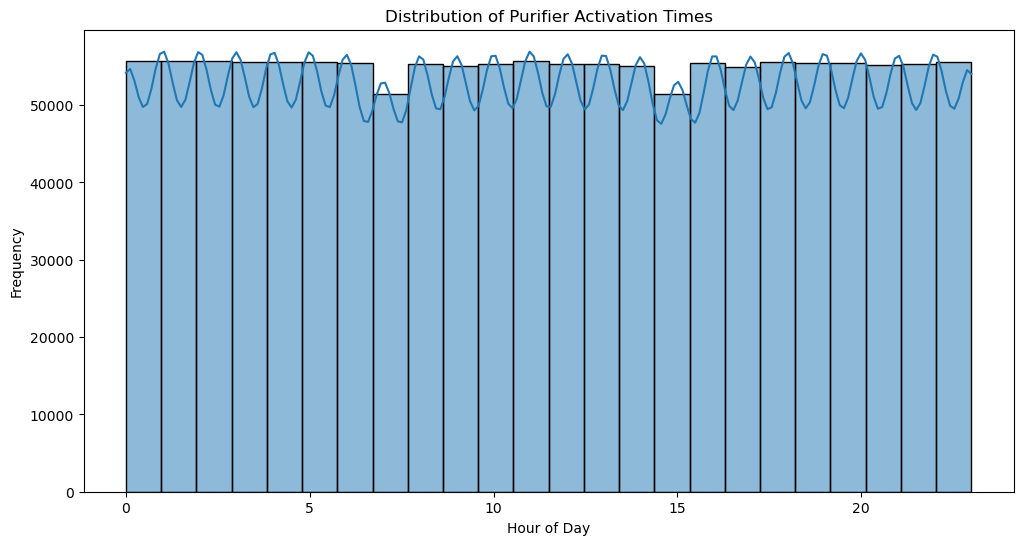

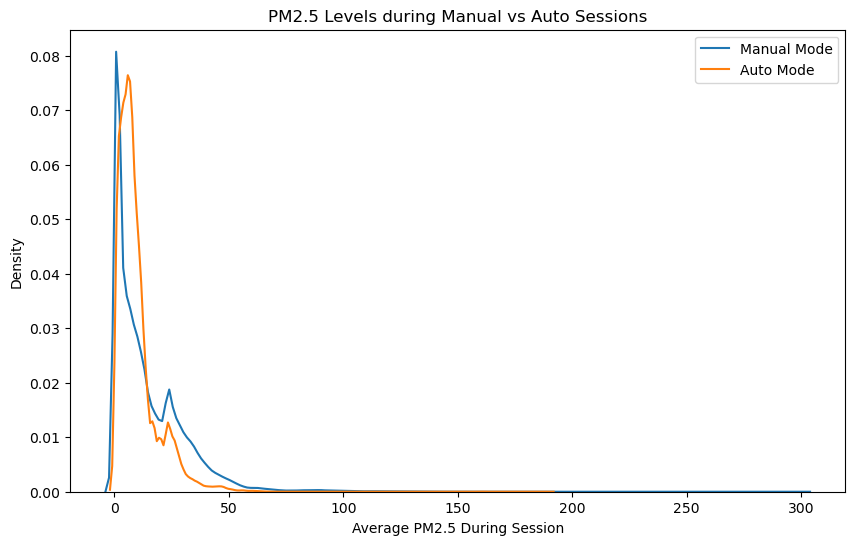

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Optional: adjust display settings
pd.set_option('display.max_columns', None)


# --- STEP 1: Feature Engineering ---
indoor['hour'] = indoor['Timestamp'].dt.hour
indoor['day_of_week'] = indoor['Timestamp'].dt.day_name()
indoor['is_on'] = indoor['Power']
indoor['is_manual_mode'] = indoor['Mode'].apply(
    lambda x: 1 if isinstance(x, str) and x.lower() == 'manual' else 0
)

# Optional: Categorize speed levels
indoor['speed_category'] = pd.cut(indoor['Speed'], bins=[0,1,2,3], labels=['low','medium','high'], right=False)

# --- STEP 2: Session Identification ---
# A new session is when power status goes from off to on
indoor = indoor.sort_values(['Member Uuid', 'Device Name', 'Timestamp'])
indoor['prev_is_on'] = indoor.groupby(['Member Uuid', 'Device Name'])['is_on'].shift(1).fillna(0)
indoor['session_start'] = ((indoor['is_on'] == 1) & (indoor['prev_is_on'] == 0)).astype(int)

# Assign session IDs
indoor['session_id'] = indoor.groupby(['Member Uuid', 'Device Name'])['session_start'].cumsum()
indoor['session_id'] = indoor.apply(lambda row: row['session_id'] if row['is_on'] == 1 else np.nan, axis=1)
indoor['session_id'] = indoor.groupby(['Member Uuid', 'Device Name'])['session_id'].ffill()

# --- STEP 3: Session Summary ---
session_summary = indoor[indoor['is_on'] == 1].groupby(['Member Uuid', 'Device Name', 'session_id']).agg({
    'Timestamp': ['min', 'max', 'count'],
    'Pm25': ['mean', 'max'],
    'Temperature': 'mean',
    'Humidity': 'mean',
    'is_manual_mode': 'mean'
}).reset_index()

session_summary.columns = ['_'.join(col).strip('_') for col in session_summary.columns.values]
session_summary['session_duration_min'] = session_summary['Timestamp_max'] - session_summary['Timestamp_min']
session_summary['session_duration_min'] = session_summary['session_duration_min'].dt.total_seconds() / 60.0

# --- STEP 4: Time-of-Day Patterns ---
plt.figure(figsize=(12,6))
sns.histplot(indoor[indoor['is_on'] == 1]['hour'], bins=24, kde=True)
plt.title("Distribution of Purifier Activation Times")
plt.xlabel("Hour of Day")
plt.ylabel("Frequency")
plt.show()

# --- STEP 5: Manual vs Auto Behavior ---
manual_sessions = session_summary[session_summary['is_manual_mode_mean'] > 0.5]
auto_sessions = session_summary[session_summary['is_manual_mode_mean'] <= 0.5]

plt.figure(figsize=(10,6))
sns.kdeplot(manual_sessions['Pm25_mean'], label='Manual Mode')
sns.kdeplot(auto_sessions['Pm25_mean'], label='Auto Mode')
plt.title("PM2.5 Levels during Manual vs Auto Sessions")
plt.xlabel("Average PM2.5 During Session")
plt.legend()
plt.show()

# --- STEP 6: User Clustering ---
user_features = session_summary.groupby('Member Uuid').agg(
    avg_session_duration=('session_duration_min', 'mean'),
    total_sessions=('session_id', 'count'),
    manual_mode_ratio=('is_manual_mode_mean', 'mean')
).reset_index()

# Fill missing values with 0
user_features[['avg_session_duration', 'total_sessions', 'manual_mode_ratio']] = user_features[['avg_session_duration', 'total_sessions', 'manual_mode_ratio']].fillna(0)


c:\Users\saisr\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


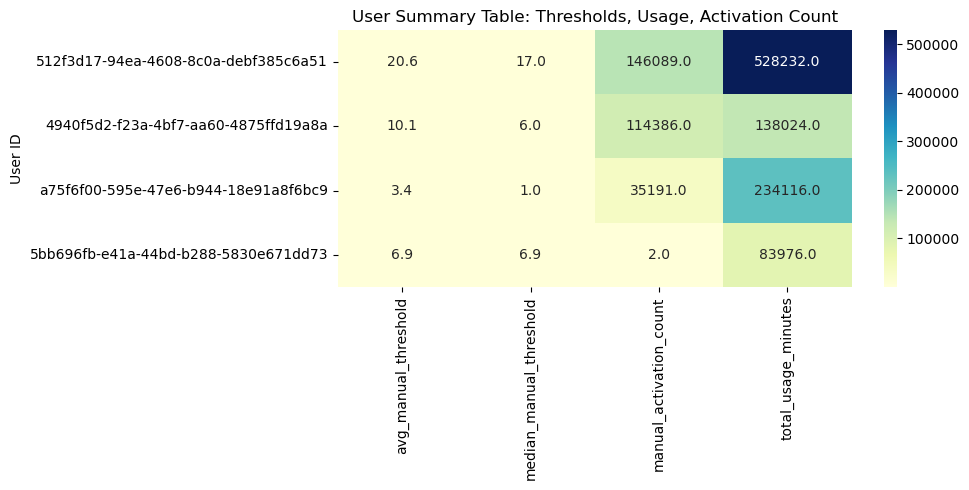

In [71]:

# Filter sessions where mode was manual
manual_sessions = session_summary[session_summary['is_manual_mode_mean'] > 0.8]

# Calculate threshold stats for manual sessions
manual_thresholds = manual_sessions.groupby('Member Uuid')['Pm25_mean'].agg(
    avg_manual_threshold='mean',
    median_manual_threshold='median',
    manual_activation_count='count'
)

# Recreate cluster labels if needed
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Features used for clustering
user_features = session_summary.groupby('Member Uuid').agg({
    'session_duration_min': 'mean',
    'session_id': 'count',
    'is_manual_mode_mean': 'mean'
}).rename(columns={
    'session_duration_min': 'avg_session_duration',
    'session_id': 'total_sessions',
    'is_manual_mode_mean': 'manual_mode_ratio'
}).reset_index()

# Clean and scale
user_features = user_features.dropna()
scaler = StandardScaler()
scaled = scaler.fit_transform(user_features.drop(columns='Member Uuid'))

# Cluster
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled)

# Add cluster column
user_features['cluster'] = clusters
cluster_labels = dict(zip(user_features['Member Uuid'], user_features['cluster']))

def assign_risk(row):
    if row['manual_activation_count'] < 3:
        return 'Low engagement'
    if row['median_manual_threshold'] <= 10:
        return 'Low risk'
    elif row['median_manual_threshold'] <= 20:
        return 'Medium risk'
    else:
        return 'High risk'

manual_thresholds['risk_category'] = manual_thresholds.apply(assign_risk, axis=1)

# Total purifier ON time per user
usage_summary = session_summary.groupby('Member Uuid')['session_duration_min'].sum().rename('total_usage_minutes')

# Start with manual thresholds
user_summary = manual_thresholds.join(usage_summary, how='outer')

# Add clusters and risk
user_summary['cluster'] = user_summary.index.map(cluster_labels)
user_summary = user_summary.fillna({
    'cluster': -1,
    'manual_activation_count': 0,
    'avg_manual_threshold': 0,
    'median_manual_threshold': 0,
    'total_usage_minutes': 0,
    'risk_category': 'No activation'
})

# Clean and format
user_summary = user_summary.sort_values('risk_category', ascending=False)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.heatmap(user_summary.drop(columns=['risk_category', 'cluster']), annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("User Summary Table: Thresholds, Usage, Activation Count")
plt.ylabel("User ID")
plt.tight_layout()
plt.show()


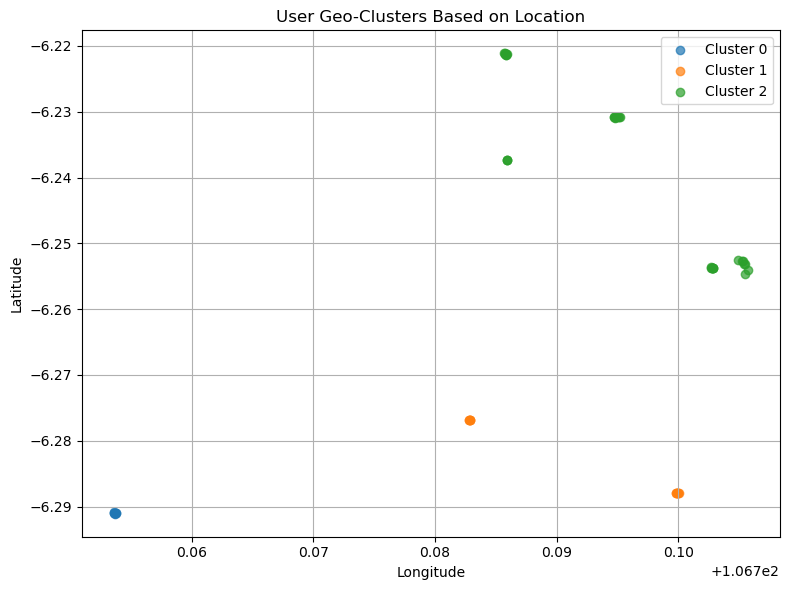

In [96]:
from sklearn.cluster import DBSCAN
import numpy as np

# Filter valid users
geo_df = indoor_meta.dropna(subset=['Latitude', 'Longitude']).copy()

coords = geo_df[['Latitude', 'Longitude']].values
coords_rad = np.radians(coords)

 # Try 3 km, or experiment with 2–5 km
epsilon = 3 / 6371.0 

db = DBSCAN(eps=epsilon, min_samples=2, algorithm='ball_tree', metric='haversine')
geo_df['geo_cluster'] = db.fit_predict(np.radians(coords))

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for cluster_id, group in geo_df.groupby('geo_cluster'):
    plt.scatter(group['Longitude'], group['Latitude'], label=f'Cluster {cluster_id}', alpha=0.7)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('User Geo-Clusters Based on Location')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [97]:
merged_indoor = pd.merge(indoor, geo_df, on='Device Name', how='left')

In [87]:
print(merged_indoor['geo_cluster'].value_counts(dropna=False))


geo_cluster
NaN    934808
2.0    768376
1.0    393966
Name: count, dtype: int64


C:\Users\saisr\AppData\Local\Temp\ipykernel_11044\1394564147.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cluster_on, x='geo_cluster', y='Power', palette='Blues_d')


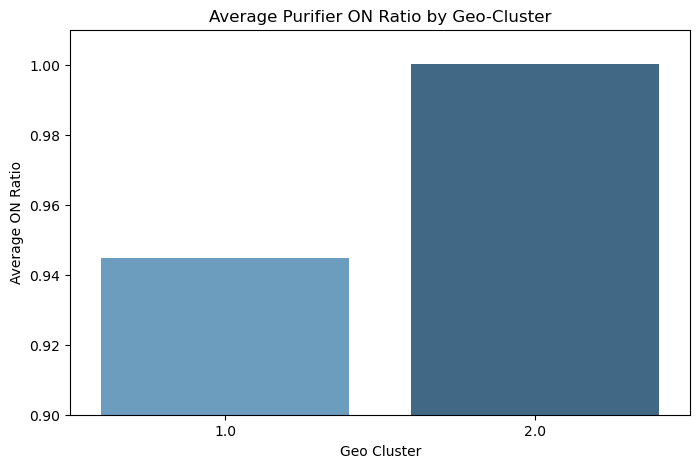

In [98]:
# Assuming you have 'merged_indoor' with geo_cluster and 'Power' columns
import seaborn as sns
import matplotlib.pyplot as plt

cluster_on = merged_indoor.groupby('geo_cluster')['Power'].mean().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=cluster_on, x='geo_cluster', y='Power', palette='Blues_d')
plt.title("Average Purifier ON Ratio by Geo-Cluster")
plt.ylabel("Average ON Ratio")
plt.xlabel("Geo Cluster")
plt.ylim(0.9, 1.01)
plt.show()
